In [ ]:
import sys
sys.executable

# Hand-written digit recognition (MNIST database)

### Based on the book by Michael Nielsen, @ http://neuralnetworksanddeeplearning.com/index.html 

### Code on GitHub @ https://github.com/mnielsen/neural-networks-and-deep-learning 

<img src="mnist_100_digits.png" style="width: 500px;"/>

#### MNIST dataset (how it is loaded)

<code>training_data</code>, <code>validation_data</code>, <code>test_data</code> are iterators containing pairs of input-output arrays:
* <code>training_data</code> contains 50000 pairs, and is used to train the network
* <code>test_data</code> contains 10000 pairs, and is used to test the performance of the network;
* <code>validation_data</code> also contains 10000 pairs and is used as extra ''testing'' data (to set hyper-parameters)

#### Setup the network and calculate the optimum parameters via Stochastic Gradient Descent of the mean-square error cost function

* Define a network with given numbers of nodes per layer (784 is the number of pixels of input images, 10 is the output vector)
<br/><br/>

* Define the parameters of the learning:
    * <code>epochs</code> is the number of complete *sweeps* over the training data
    <br/><br/>
    
    * <code>mini_batch_size</code> is the number of data points used for the evaluation of the gradient (i.e. between two steepest descent steps), $M$
    <br/><br/>
    
    * <code>eta</code> is the learning rate, $\eta$
    <br/><br/>
    
    * $\ldots$

* Define a cost function (defined inside the <code>Network</code> class), i.e. the mean-square error function
    
    $$
        C = \frac{1}{N}\sum_x \underbrace{\big\| a^L(x) - y(x) \big\|^2}_{C_x}
    $$
    
* **Train the network**.  For every epoch, 

    1. shuffle the training data (or the portion of training data passed to the SGD function) and divide them into mini-batches of size $M$;
    <br/><br/>
    
    2. for each mini-batch calculate the gradient of the cost with respect to the parameters, as $ \nabla_{w,b} C \simeq \overline{\nabla_{w,b} C} $ (where $\,\overline{\,\bullet\,}\,$ indicates the sample mean over the mini-batch) using the **backpropagation** algorithm (see below) and take a gradient descent step as $$
            w \leftarrow w - \eta\,\overline{\frac{\partial C}{\partial w}}
            \qquad \textrm{and} \qquad
            b \leftarrow b - \eta\,\overline{\frac{\partial C}{\partial b}}$$
    <br/><br/>

    4. Test the performance with the <code>test_data</code>

#### How backpropagation works

For a given input $x$:

1. **Set the input** as $a^1_j(x) = x_j$
<br/><br/>

2. **Feedforward**: For all the subsequent layers, compute $a_j^L(x)$, by iterating $ a_i^l = \sigma(z_i^l)$ where

    $$ z_i^l = \sum_j w^{l-1}_{ij} a_j^{l-1} $$
    for all $l = 2,\ldots L$
<br/><br/>
    
3. Calculate the output **error**:

    $$ \delta_j^L(x) = \sigma'\big(z^L_j\big)\frac{\partial C_x}{\partial a^L_j} $$
    <br/>

4. **Propagate** the error **backward**: for all the previous layers, $l = L-1, \ldots 2$, iterate

    $$ \delta^l_i = \sigma'\big(z^l_i\big)\,\sum_j w_{ji}^{l+1} \delta_j^{l+1} $$
    <br/>
    
5. **Derivatives of the cost** with respect to weights and biases are

    $$
        \frac{\partial C_x}{\partial w^{l}_{ij}} = a_j^{l-1} \delta^l_i
        \qquad \textrm{ and } \qquad
        \frac{\partial C_x}{\partial b_i} = \delta^l_i
    $$
    
    
These derivatives are accumulated into the sample mean over the mini-batch data,

$$
    \overline{\frac{\partial C}{\partial w^{l}_{ij}}} \simeq \frac{1}{M}\sum_x \frac{\partial C_x}{\partial w^{l}_{ij}}
        \qquad \textrm{ and } \qquad
        \overline{\frac{\partial C}{\partial b^{l}_{j}}} \simeq \frac{1}{M}\sum_x \frac{\partial C_x}{\partial b^{l}_{i}}
$$

In [ ]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

import network
net = network.Network([784, 30, 10])

epochs = 30
mini_batch_size = 10
eta = 3.0

### uncomment to reduce the training data set
n_training = 1000  # < 50000
training_data = list(training_data)[:n_training]

net.SGD(training_data, epochs, mini_batch_size, eta,
        test_data=test_data)

## Improvements

Performance can be improved by:
1. initializing the **weights** wisely
1. choosing a more **suitable cost function** (Cross-entropy vs Mean-square-error)
2. reducing overfitting through **regularization**
    1. adding extra terms in the cost ($L_1$ or $L_2$ regularization of the weights)
    2. with *dropout*

### 1. Weight initialization

By default, the <code>network2</code> class initializes the weights as Gaussian variables with standard deviation equal to $1/\sqrt{\textrm{input neurons}}$: as a consequence, both the weighted sum and the biases for the neuron are of order 1, avoiding saturation and hence learning slowdown.

In [ ]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

import network2
net = network2.Network([784, 30, 10], cost=network2.QuadraticCost)

## uncommenting this line, the code is equivalent to the one above
# net.large_weight_initializer()

epochs = 30
mini_batch_size = 10
eta = 3.0

### uncomment to reduce the training data set
#n_training = 1000  # < 50000
#training_data = list(training_data)[:n_training]

net.SGD(training_data, epochs, mini_batch_size, eta,
        evaluation_data=test_data,
        monitor_evaluation_accuracy=True)

### 2. Cross-entropy cost function

The Cross-entropy cost is defined as

$$
    C = \frac{1}{N}\sum_x \underbrace{\sum_i \big[ -y_j(x)\,\log a_j^L(x) - (1-y_j(x))\,\log\big( 1 - a^L_j(x) \big) \big]}_{C_x}
$$

In [ ]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

import network2

# notice the different specification for the function 'cost'
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
net.large_weight_initializer()

epochs = 30
mini_batch_size = 10
eta = 0.5

### uncomment to reduce the training data set
#n_training = 1000  # < 50000
#training_data = list(training_data)[:n_training]

net.SGD(training_data, epochs, mini_batch_size, eta,
        evaluation_data=test_data,
        monitor_evaluation_accuracy=True)

### 3. Reducing overfitting: $L_2$ regularization

An extra term is added to the cost, which penalizes large values of the weights:
$$ C = C^{0} + \frac{\lambda}{n} \sum_\textrm{all links} w^2 $$

where $C^{0}$ is the unregularized cost, i.e. the quadratic cost or the cross-entropy cost.

This is equivalent to changing the SGD update rule for the weights to
$$
    w \leftarrow \Big( 1 - \frac{\eta\,\lambda}{n} \Big) w - \eta \overline{\frac{\partial C^{0}_x}{\partial w}}
$$

where $\,\overline{\,\bullet\,}\,$ indicates the sample mean over the mini-batch

In [36]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

import network2
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
net.large_weight_initializer()

n_training = 50000
n_testing = 10000

epochs = 30
mini_batch_size = 10
eta = 0.5
lmbda = 1.0

### uncomment to reduce the training/testing data set
n_testing = 1000  # < 10000
n_training = 5000  # < 50000


evaluation_cost, evaluation_accuracy, training_cost, training_accuracy = net.SGD(
    list(training_data)[:n_training],  #training_data,
    epochs, mini_batch_size, eta,
    lmbda = lmbda,
    evaluation_data=list(test_data)[:n_testing], #evaluation_data=test_data,
    monitor_evaluation_cost=False,
    monitor_evaluation_accuracy=True,
    monitor_training_cost=False,
    monitor_training_accuracy=True)

evaluation_accuracy = 100*np.array(evaluation_accuracy)/n_testing
training_accuracy = 100*np.array(training_accuracy)/n_training

Epoch 0 training complete
Accuracy on training data: 4170 / 5000
Accuracy on evaluation data: 768 / 1000
Epoch 1 training complete
Accuracy on training data: 4490 / 5000
Accuracy on evaluation data: 832 / 1000
Epoch 2 training complete
Accuracy on training data: 4535 / 5000
Accuracy on evaluation data: 847 / 1000
Epoch 3 training complete
Accuracy on training data: 4627 / 5000
Accuracy on evaluation data: 862 / 1000
Epoch 4 training complete
Accuracy on training data: 4724 / 5000
Accuracy on evaluation data: 873 / 1000
Epoch 5 training complete
Accuracy on training data: 4741 / 5000
Accuracy on evaluation data: 870 / 1000
Epoch 6 training complete
Accuracy on training data: 4785 / 5000
Accuracy on evaluation data: 884 / 1000
Epoch 7 training complete
Accuracy on training data: 4815 / 5000
Accuracy on evaluation data: 871 / 1000
Epoch 8 training complete
Accuracy on training data: 4838 / 5000
Accuracy on evaluation data: 876 / 1000
Epoch 9 training complete
Accuracy on training data: 48

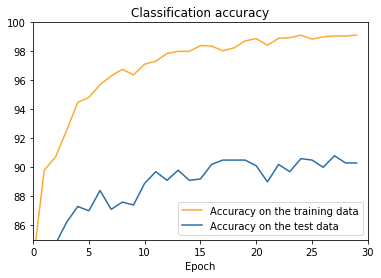

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(0, 30, 1), training_accuracy, color='#FFA933',
            label="Accuracy on the training data")
ax.plot(np.arange(0, 30, 1), evaluation_accuracy, color='#2A6EA6', 
            label="Accuracy on the test data")
ax.set_xlim(0, 30)
ax.set_xlabel('Epoch')
ax.set_ylim(85, 100)
ax.set_title('Classification accuracy')
plt.legend(loc="lower right")
plt.show()

#### Other methods to reduce overfitting

* Early stopping
* Dropout

## Putting everything together 

In [ ]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

import network2
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
#net.large_weight_initializer()

n_training = 50000
epochs = 30
mini_batch_size = 10
eta = 0.5
lmbda = 5.0

### uncomment to reduce the training data set
n_training = 1000  # < 50000
training_data = list(training_data)[:n_training]

evaluation_cost, evaluation_accuracy, training_cost, training_accuracy = net.SGD(
    training_data, epochs, mini_batch_size, eta,
    lmbda = lmbda,
    evaluation_data=validation_data,
    monitor_evaluation_accuracy=True,
    monitor_evaluation_cost=False,
    monitor_training_accuracy=True,
    monitor_training_cost=False)

evaluation_accuracy = .01*np.array(evaluation_accuracy)
training_accuracy = 100/n_training*np.array(training_accuracy)

<br/><br/>
## Convolutional Neural Network

Have a look at Chapter 6 of Nielsen book

In [ ]:
import network3
from network3 import Network
from network3 import ConvPoolLayer, FullyConnectedLayer, SoftmaxLayer
training_data, validation_data, test_data = network3.load_data_shared()
mini_batch_size = 10

net = Network([
    FullyConnectedLayer(n_in=784, n_out=100),
    SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)

net.SGD(training_data, 60, mini_batch_size, 0.1, 
    validation_data, test_data)